In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
# data handling
import geopandas as gpd
import pandas as pd
import numpy as np
import utils

# data analysis
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import my_ML_algo as algo

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, f1_score

change_type_map = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
                   'Mega Projects': 5}



In [4]:
# Read csvs
print("--- read .csv files ---")
train_df = gpd.read_file('train.geojson', index_col=0)
# train_df = train_df.dropna()
test_df = gpd.read_file('test.geojson', index_col=0)
# test_df = test_df.dropna()

--- read .csv files ---


In [5]:
print(train_df.shape, test_df.shape)

(296146, 45) (120526, 44)


In [6]:
######## Feature engineering ########
print("--- Feature engineering ---")


def get_features(df, dataset_type):
    dic_features = {"names":[],"features":[]}

    # geometry features
    perimeter = np.asarray(df['geometry'].length)
    perimeter = np.expand_dims(perimeter, axis=-1)
    dic_features["features"].append(perimeter)
    dic_features["names"].append("perimeter")

    area_values = np.asarray(df['geometry'].area)
    area_values = np.expand_dims(area_values, axis=-1)
    dic_features["features"].append(area_values)
    dic_features["names"].append("area_values")

    def get_min_length_ratio(exte):
        x, y = exte.xy
        lengths = [
            np.sqrt((x[i] - x[i + 1]) ** 2 + (y[i] - y[i + 1]) ** 2) for i in range(4)
        ]
        return np.min(lengths)

    def get_max_length_ratio(exte):
        x, y = exte.xy
        lengths = [
            np.sqrt((x[i] - x[i + 1]) ** 2 + (y[i] - y[i + 1]) ** 2) for i in range(4)
        ]
        return np.max(lengths)

    
    min_lengths = np.asarray(df["geometry"].exterior.apply(get_min_length_ratio))
    min_lengths = np.expand_dims(min_lengths,axis=-1)

    max_lengths = np.asarray(df["geometry"].exterior.apply(get_max_length_ratio))
    max_lengths = np.expand_dims(max_lengths,axis=-1)

    ratio_min_max_lengths = min_lengths/max_lengths
    dic_features["features"].append(ratio_min_max_lengths)
    dic_features["names"].append("ratio_min_max_lengths")

    # dic_features["features"].append(min_lengths)
    # dic_features["names"].append("min_lengths")

    # dic_features["features"].append(max_lengths)
    # dic_features["names"].append("max_lengths")

    # diameter
    def get_coords(geom):
        coords = list(geom.exterior.coords)
        return (coords)

    def get_diameters(coord):
        arr_coord = np.array(coord)
        distances = utils.get_distances(arr_coord,arr_coord)
        return np.max(distances)

    coords = df.geometry.apply(get_coords)
    diameters = coords.apply(get_diameters)
    diameters = np.asarray(diameters)
    diameters = np.expand_dims(diameters,axis=-1)
    dic_features["features"].append(diameters)
    dic_features["names"].append("diameters")

    ratio_area_over_diameter = perimeter/diameters
    dic_features["features"].append(ratio_area_over_diameter)
    dic_features["names"].append("ratio_area_over_diameter")

    ratio_perimeter_over_diameter = area_values/diameters
    dic_features["features"].append(ratio_perimeter_over_diameter)
    dic_features["names"].append("ratio_perimeter_over_diameter")

    # geography features
    mlb_urban_type = MultiLabelBinarizer()
    urban_type = np.asarray(df["urban_type"].apply(lambda x: x.split(",") if x!="N,A" else [x]))
    urban_type = [urban_type[row] for row in range(urban_type.shape[0])]
    urban_type = mlb_urban_type.fit_transform(urban_type)
    dic_features["features"].append(urban_type)
    dic_features["names"]+=list(mlb_urban_type.classes_)

    mlb_geography_type = MultiLabelBinarizer()
    geography_type = np.asarray(df["geography_type"].apply(lambda x: x.split(",") if x!="N,A" else [x]))
    geography_type = mlb_geography_type.fit_transform(geography_type)
    dic_features["features"].append(geography_type)
    dic_features["names"]+=list(mlb_geography_type.classes_)

    # add sequence features

    # kept_columns_dense_32 = np.arange(32)
    # model_dense_32_output = np.load(f"save/outputs/model_dense_32_{dataset_type}_output_5000_train_steps_no_val.npz")["arr_0"][:,kept_columns_dense_32]
    # dic_features["features"].append(model_dense_32_output)
    # dic_features["names"]+=[f"model_dense_32_output_{j}" for j in kept_columns_dense_32]

    # kept_columns_dense_16 = np.arange(16)
    # model_dense_16_output = np.load(f"save/outputs/model_dense_16_{dataset_type}_output_5000_train_steps_no_val.npz")["arr_0"]
    # model_dense_16_output = model_dense_16_output[:,kept_columns_dense_16]
    # dic_features["features"].append(model_dense_16_output)
    # dic_features["names"]+=[f"model_dense_16_output_{j}" for j in kept_columns_dense_16]

    
    # PCA on sequence features :

    model_dense_32_output = np.load(f"save/outputs/model_dense_32_{dataset_type}_output_5000_train_steps_no_val.npz")["arr_0"]
    
    PCA_model_dense_32_output = algo.apply_PCA(model_dense_32_output)
    print("PCA 32 : ",PCA_model_dense_32_output.shape)
    dic_features["features"].append(PCA_model_dense_32_output)
    dic_features["names"]+=[f"PCA_model_dense_32_output_{j}" for j in np.arange(PCA_model_dense_32_output.shape[-1])]


    model_dense_16_output = np.load(f"save/outputs/model_dense_16_{dataset_type}_output_5000_train_steps_no_val.npz")["arr_0"]
    PCA_model_dense_16_output = algo.apply_PCA(model_dense_16_output)
    print("PCA 16 : ",PCA_model_dense_16_output.shape)
    dic_features["features"].append(PCA_model_dense_16_output)
    dic_features["names"]+=[f"PCA_model_dense_16_output_{j}" for j in np.arange(PCA_model_dense_16_output.shape[-1])]


    # for feat in features:
    #     print(feat.shape)

    res = np.concatenate(dic_features["features"], axis=-1)

    return res,dic_features


train_x,train_dic_features = get_features(train_df,dataset_type="train")
train_y = train_df['change_type'].apply(lambda x: change_type_map[x])

index_x = test_df["index"]
test_x,_ = get_features(test_df,dataset_type="test")

print("train_x.shape, train_y.shape, test_x.shape :\n",
      train_x.shape, train_y.shape, test_x.shape)


--- Feature engineering ---


C:\Users\jtros\AppData\Local\Temp\ipykernel_2900\2835160032.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  perimeter = np.asarray(df['geometry'].length)
C:\Users\jtros\AppData\Local\Temp\ipykernel_2900\2835160032.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  area_values = np.asarray(df['geometry'].area)


PCA 32 :  (296146, 12)
PCA 16 :  (296146, 4)


C:\Users\jtros\AppData\Local\Temp\ipykernel_2900\2835160032.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  perimeter = np.asarray(df['geometry'].length)
C:\Users\jtros\AppData\Local\Temp\ipykernel_2900\2835160032.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  area_values = np.asarray(df['geometry'].area)


PCA 32 :  (120526, 12)
PCA 16 :  (120526, 4)
train_x.shape, train_y.shape, test_x.shape :
 (296146, 40) (296146,) (120526, 40)


In [11]:
sfs=SFS(RandomForestClassifier(verbose=1,n_jobs=-1),
          k_features=2,
          scoring='f1_macro',
          verbose=2,
          cv=5, n_jobs=-1)
sfs.fit(train_x,train_y)
print(np.arange(train_x.shape[-1])[sfs.get_support()])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min


In [8]:
######## Training ########
print("--- train ---")
rnd_clf = RandomForestClassifier(verbose=1,n_jobs=-1)

rnd_clf.fit(train_x,train_y)
pred_y = rnd_clf.predict(train_x)
train_rnd_clf_f1_score = f1_score(pred_y, train_y,average='macro')
print("f1_score on training set :", train_rnd_clf_f1_score)
print("prediction on test set shape :", pred_y.shape)

utils.display_feature_importances(train_dic_features,rnd_clf)

print([estimator.get_depth() for estimator in rnd_clf.estimators_])
print([estimator.get_n_leaves() for estimator in rnd_clf.estimators_])

utils.plot_and_save_confusion_matrix(pred_y,train_y,"./results/confusion_matrix_simple_rnd_clfxCNN.png")


k_fold_number = 0
val_scores = [-1]
if k_fold_number>1:
    def display_scores(scores):
        print("Scores:",scores)
        print("Mean",scores.mean())
        print("Std:",scores.std())
    val_scores = cross_val_score(rnd_clf,train_x,train_y,scoring="f1_macro",cv=k_fold_number)
    display_scores(val_scores)


    utils.save_experiment_in_excel("./results/automatic_study_features_rndxCNN.xlsx",rnd_clf,train_rnd_clf_f1_score,k_fold_number,val_scores,train_dic_features,)


--- train ---


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.3s finished


f1_score on training set : 0.9999972175022197
prediction on test set shape : (296146,)
perimeter importance: 0.04521681245554552
area_values importance: 0.002226980757795324
ratio_min_max_lengths importance: 0.02805841133994838
urban_type importance: 0.009286252166873316
model_dense_6_output_0 importance: 0.0005370045845868031
model_dense_6_output_1 importance: 0.04027269630780477
model_dense_6_output_2 importance: 0.0005719097053821394
model_dense_6_output_3 importance: 0.0054256576719083315
model_dense_6_output_4 importance: 0.0005393376383719886
model_dense_6_output_5 importance: 0.056424529450713655
PCA_model_dense_32_output_0 importance: 0.024575080073833397
PCA_model_dense_32_output_1 importance: 0.06182720688138132
PCA_model_dense_32_output_2 importance: 0.03667726480723228
PCA_model_dense_32_output_3 importance: 0.08272258590746674
PCA_model_dense_32_output_4 importance: 0.027071093924304318
PCA_model_dense_32_output_5 importance: 0.04232778293734615
PCA_model_dense_32_output_6

In [7]:
train_dic_features["names"][22]

'PCA_model_dense_16_output_2'

In [5]:
rnd_clf = RandomForestClassifier(verbose=1,n_jobs=-1)
rnd_clf.fit(sfs.transform(train_x),train_y)
pred_y = rnd_clf.predict(sfs.transform(train_x))
train_rnd_clf_f1_score = f1_score(pred_y, train_y,average='macro')
print("f1_score on training set :", train_rnd_clf_f1_score)
print("prediction on test set shape :", pred_y.shape)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.8s


f1_score on training set : 0.9999810915692029
prediction on test set shape : (296146,)


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    2.9s finished


C:\Users\clara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\clara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


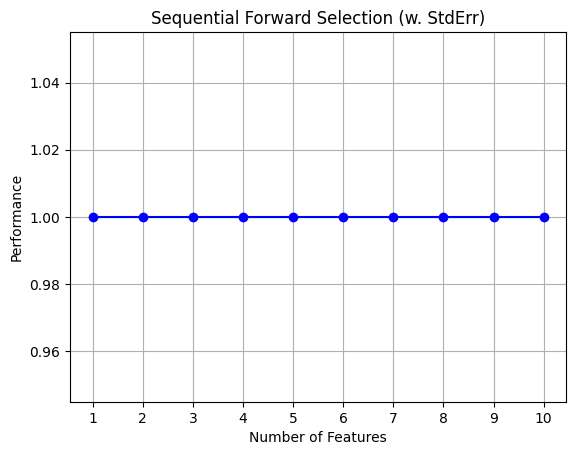

In [44]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [6]:
######## Save results to submission file ########
pred_y = rnd_clf.predict(sfs.transform(test_x))
print("--- save ---")
pred_df = pd.DataFrame(pred_y, columns=['change_type'])
pred_df.to_csv("greedy.csv", index=True, index_label='Id')

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


--- save ---
